In [1]:
from pathlib import Path
import warnings

import geopandas as gpd
import pandas as pd
from rasterio.plot import reshape_as_image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Local imports
from mlp import MLP, MLPDataset, train_test_ae_mlp


warnings.filterwarnings("ignore", category=RuntimeWarning)


# Constants
BATCH_SIZE = 1028
DATA_DIR = Path(r"C:\Users\Peter\gh\rasmussen-705.603\data\FinalProject")
EPOCHS = 30
GAMMA = 0.1
LAT_SPACE_SIZES = [2, 4, 16, 64, 256,]
LRS = [0.5, 0.1]
OUTPUT_BANDS = ["blue", "green", "red", "nir08", "swir16", "swir22", "ndvi", "qa"]
STEP_SIZES = [5, 10, 15]
TR_VAL_SPLIT = 0.9
WEIGHT_DECAY = 5e-4

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define directories
raw_dir = DATA_DIR / "raw"
interim_dir = DATA_DIR / "interim"
processed_dir = DATA_DIR / "processed"
cogs_dir = interim_dir / "_cogs-4-30"
autoencoder_dir = processed_dir / "autoencoder"
models_dir = interim_dir / "models"
scores_dir = interim_dir / "scores"
models_dir.mkdir(exist_ok=True, parents=True)
scores_dir.mkdir(exist_ok=True, parents=True)

In [2]:
# encoded = model.encoder(batch)
# encoded = encoded.view(-1, model.CNN_flatten)
# latent_space1 = model.latent_space1(encoded)
# latent_space2 = model.latent_space2(latent_space1)
# latent_space3 = model.latent_space3(latent_space2)
# latent_space3.shape, batch.shape
# decoded = latent_space3.view(-1, model.CNN[1], model.CNN[2], model.CNN[3])


In [2]:
regions = gpd.read_file(raw_dir / "regions.geojson").set_index("event_key")
for region, region_meta in regions.iterrows():
    break

In [3]:
dataset = MLPDataset(cogs_dir, OUTPUT_BANDS, region=region, train=False)

In [24]:
import rasterio as rio
with rio.open(r"C:\Users\Peter\gh\rasmussen-705.603\data\FinalProject\interim\cogs\af-kharkamar-2022_2017-11-20.tif") as rast:
    arr = rast.read()

1

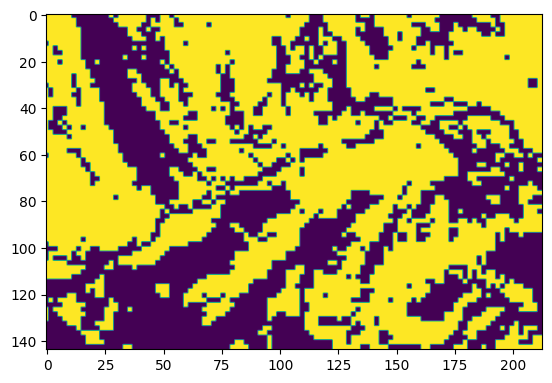

In [37]:
import matplotlib.pyplot as plt
plt.imshow(arr[-1]==5)

In [11]:
dataset.cube[:, :, :, -2]

array([[[-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533],
        [-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533],
        [-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533],
        ...,
        [-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533],
        [-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533],
        [-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
         -0.12877533, -0.12877533]],

       [[-0.12877533, -0.12877533, -0.12877533, ..., -0.12877533,
          7.764047  ,  7.764047  ],
        [-0.12877533, -0.12877533, -0.12877533, ...,  7.764047  ,
          7.764047  ,  7.764047  ],
        [-0.12877533, -0.12877533, -0.12877533, ...,  7.764047  ,
          7.764047  ,  7.764047  ],
        ...,
        [-0.12877533, -0.12877533, -0.12877533, ..., -

In [125]:

loader = DataLoader(dataset, batch_size=1028, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1028, shuffle=False)
te_loader = DataLoader(te_dataset, batch_size=1028, shuffle=False)

len(tr_loader), len(val_loader), len(te_loader)

(2504, 279, 310)

In [126]:
class AE(nn.Module):
    def __init__(self, in_features, hidden_neurons):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_features, out_features=hidden_neurons
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_neurons, out_features=in_features
        )

    def forward(self, features):
        hidden_z = self.encoder_hidden_layer(features)
        hidden_y = torch.relu(hidden_z)
        output_z = self.decoder_output_layer(hidden_y)
        output_y = torch.relu(output_z)
        return output_y

In [150]:
batch_size = 1028

In [151]:
len(batch)

827

In [130]:
models_dir = interim_dir / "models"
models_dir.mkdir(exist_ok=True, parents=True)
scores_dir = interim_dir / "scores"
scores_dir.mkdir(exist_ok=True, parents=True)

LAT_SPACE_SIZES = [2, 4, 16, 64, 256,]
STEP_SIZES = [5, 10, 15]
LRS = [0.5, 0.1]

# LAT_SPACE_SIZES = [16, 64, 256,]
# STEP_SIZES = [5, 5, 5]
# LRS = [0.0015, 0.0015, 0.0015]

iter_params = zip(LAT_SPACE_SIZES, STEP_SIZES, LRS)
LR = 0.5
EPOCHS = 30
GAMMA = 0.1

tr_val_losses = []
te_losses = []


for step_size in STEP_SIZES:
    for lr_ in LRS:

        print(f"Train model with step_size={step_size} and lr={lr_}.")
        min_val_loss = np.inf
        model = AE(
            in_features=8,
            hidden_neurons=2,
            )
        model.to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=5e-4, fused=True)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=GAMMA)
    
        for epoch in range(1, EPOCHS + 1):
            tr_loss = 0
            lr = scheduler.get_last_lr()[0]
            for batch_ix, batch in enumerate(tr_loader):
                
                # Move data to device
                batch = batch.to(device)
                
                # Forward
                model.train()
                output = model(batch)
                loss = criterion(output, batch)

                # Backward
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # Training loss
                tr_loss += loss.item()
            
            batch_tr_loss = tr_loss / len(tr_loader)
            print(f"[{step_size}][{lr_:.3f}][{epoch}]: batch_tr_loss={batch_tr_loss:.4f}, lr={lr:.6f}")
                
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for val_batch_ix, val_batch in enumerate(val_loader):
                    val_batch = val_batch.to(device)
                    output = model(val_batch)
                    loss = criterion(output, val_batch)
                    val_loss += loss.item()
            batch_val_loss = val_loss / len(val_loader)

            print(f"[{step_size}][{lr_:.3f}][{epoch}]: batch_val_loss={batch_val_loss:.4f}, lr={lr:.6f}")
            if batch_val_loss < min_val_loss:
                min_val_loss = batch_val_loss
                torch.save(model.state_dict(), models_dir / f"mlp-autoencoder-{step_size}-{lr_:.3f}.pt")
                print(f"[{step_size}][{lr_:.3f}][{epoch}]: Saved model b/c val_loss at all-time low.")
            else:
                print(f"[{step_size}][{lr_:.3f}][{epoch}]: Did not save model b/c val_loss too high.")
            
            tr_val_losses.append(dict(
                step_size=step_size,
                lr=lr_,
                stepped_lr=lr,
                epoch=epoch,
                batch_tr_loss=batch_tr_loss,
                batch_val_loss=batch_val_loss,
            ))
            pd.DataFrame(tr_val_losses).to_csv(scores_dir / "tr_val_losses.csv")
            
            scheduler.step()
    
        te_loss = 0
        with torch.no_grad():
            for te_batch_ix, te_batch in enumerate(te_loader):
                te_batch = te_batch.to(device)
                output = model(te_batch)
                loss = criterion(output, te_batch)
                te_loss += loss.item()
        batch_te_loss = te_loss / len(te_loader)
        te_losses.append(dict(
            step_size=step_size,
            lr=lr_,
            batch_te_loss=batch_te_loss,
        ))
        pd.DataFrame(te_losses).to_csv(scores_dir / "te_losses.csv")


tr_val_summary = pd.DataFrame(tr_val_losses)
te_summary = pd.DataFrame(te_losses)

tr_val_summary.to_csv(scores_dir / "tr_val_summary.csv")
te_summary.to_csv(scores_dir / "te_summary.csv")

Train model with step_size=5 and lr=0.5.
[5][0.500][1]: tr_loss=0.7421, lr=0.500000
[5][0.500][1]: val_loss=0.5991, lr=0.500000
[5][0.500][1]: Saved model b/c val_loss at all-time low.
[5][0.500][2]: tr_loss=0.6016, lr=0.500000
[5][0.500][2]: val_loss=0.6355, lr=0.500000
[5][0.500][2]: Did not save model b/c val_loss too high.
[5][0.500][3]: tr_loss=0.6791, lr=0.500000
[5][0.500][3]: val_loss=0.9366, lr=0.500000
[5][0.500][3]: Did not save model b/c val_loss too high.
[5][0.500][4]: tr_loss=0.7847, lr=0.500000
[5][0.500][4]: val_loss=0.7519, lr=0.500000
[5][0.500][4]: Did not save model b/c val_loss too high.
[5][0.500][5]: tr_loss=0.7579, lr=0.500000
[5][0.500][5]: val_loss=0.6415, lr=0.500000
[5][0.500][5]: Did not save model b/c val_loss too high.
[5][0.500][6]: tr_loss=0.5581, lr=0.050000
[5][0.500][6]: val_loss=0.5533, lr=0.050000
[5][0.500][6]: Saved model b/c val_loss at all-time low.
[5][0.500][7]: tr_loss=0.4594, lr=0.050000
[5][0.500][7]: val_loss=0.3625, lr=0.050000
[5][0.50

In [144]:
optimal_step_size = int(tr_val_summary.sort_values(by="val_loss").iloc[0].to_dict()["step_size"])
optimal_lr = tr_val_summary.sort_values(by="val_loss").iloc[0].to_dict()["lr"]
optimal_step_size, optimal_lr

(10, 0.5)

In [147]:
model_src = models_dir / f"mlp-autoencoder-{optimal_step_size}-{optimal_lr:.3f}.pt"


True

In [148]:
new_model = AE(in_features=8, hidden_neurons=2)
new_model.load_state_dict(torch.load(model_src))


<All keys matched successfully>